In [1]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
from datasets import load_from_disk
from datasets import load_dataset
# import datasets

/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %pip install torch

In [3]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
so_ori = load_dataset("mispeech/speechocean762")
so_ori['train'][0]

{'accuracy': 8,
 'completeness': 10.0,
 'fluency': 9,
 'prosodic': 9,
 'text': 'WE CALL IT BEAR',
 'total': 8,
 'words': [{'accuracy': 10,
   'phones': ['W', 'IY0'],
   'phones-accuracy': [2.0, 2.0],
   'stress': 10,
   'text': 'WE',
   'total': 10,
   'mispronunciations': []},
  {'accuracy': 10,
   'phones': ['K', 'AO0', 'L'],
   'phones-accuracy': [2.0, 1.8, 1.8],
   'stress': 10,
   'text': 'CALL',
   'total': 10,
   'mispronunciations': []},
  {'accuracy': 10,
   'phones': ['IH0', 'T'],
   'phones-accuracy': [2.0, 2.0],
   'stress': 10,
   'text': 'IT',
   'total': 10,
   'mispronunciations': []},
  {'accuracy': 6,
   'phones': ['B', 'EH0', 'R'],
   'phones-accuracy': [2.0, 1.0, 1.0],
   'stress': 10,
   'text': 'BEAR',
   'total': 6,
   'mispronunciations': []}],
 'speaker': '0001',
 'gender': 'm',
 'age': 6,
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x11518b0e0>}

In [4]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
from datasets import concatenate_datasets
                                                        
# Add train/test flags                                             
train_with_flag = so_ori["train"].add_column("is_train", [True] * len(so_ori["train"]))                                              
test_with_flag = so_ori["test"].add_column("is_train", [False] * len(so_ori["test"])) 

# Combine into single dataset                                      
so_everything = concatenate_datasets([train_with_flag,test_with_flag]) 

# 3. Extract phoneme accuracies and create uttid:                    
def process_example(example, idx):                                 
       return {                                                       
              'uttid': f"utterance_{idx}",  # or extract from audio path 
              'phoneme_accuracies': [acc for word in example['words'] for
       acc in word['phones-accuracy']],                                  
             'cmu_ipa_phonetic_transcription': example.get('text', ''), 
       # use text as fallback                                            
              'cmu_ipa_mispronunciation_transcription':                  
      example.get('text', '')  # use text as fallback                    
          }                                                              
                                                                         
so_everything = so_everything.map(process_example,with_indices=True) 

# 4. Select desired columns:                                         
so_everything_ = so_everything.select_columns(['age', 'uttid', 'phoneme_accuracies', 'is_train'               
         # Add cmu_ipa_* columns if needed after processing             
    ])                            


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5754.96 examples/s]


In [5]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
# so_everything_ = so_everything.remove_columns([
#     'accuracy', 'completeness', 'fluency', 'prosodic', 'text', 'total',
#     'words', 'speaker', 'gender', 'audio', 'phonetic_transcription',
#     'phonetic_transcription_ipa', 'alignment', 'pure_alignment',
#     'phonetic_transcription_mispronunced', 'mispronounced', 'segment'
# ])

In [6]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
def extract_phoneme_accuracies(example):
    return {
        'phoneme_accuracies': [
            acc for word in example['words'] for acc in word['phones-accuracy']
        ]
    }
so_everything = so_everything.map(extract_phoneme_accuracies)


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6296.22 examples/s]


In [7]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
# train_uttids = set(entry["path"] for entry in so_ori["train"]["audio"])
train_uttids = set(range(len(so_ori["train"])))
print(len(train_uttids))
print(so_everything_[0])

2500
{'age': 6, 'uttid': 'utterance_0', 'phoneme_accuracies': [2.0, 2.0, 2.0, 1.8, 1.8, 2.0, 2.0, 2.0, 1.0, 1.0], 'is_train': True}


In [8]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
def add_is_train_flag(example):
    return {"is_train": example["uttid"] in train_uttids}

so_everything_ = so_everything_.map(add_is_train_flag)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 46280.03 examples/s]


In [9]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
import pandas as pd
so_everything_df = pd.DataFrame(so_everything_)
so_everything_df

,age,uttid,phoneme_accuracies,is_train
0,6,utterance_0,"[2.0, 2.0, 2.0, 1.8, 1.8, 2.0, 2.0, 2.0, 1.0, ...",False
1,6,utterance_1,"[2.0, 1.4, 1.4, 2.0, 1.2, 2.0, 2.0, 2.0, 2.0, ...",False
2,6,utterance_2,"[1.8, 2.0, 2.0, 2.0, 1.8, 2.0, 1.8, 2.0, 2.0, ...",False
3,6,utterance_3,"[2.0, 2.0, 2.0, 2.0, 1.8, 2.0, 2.0, 2.0, 2.0, ...",False
4,6,utterance_4,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.8, 2.0, 2.0, ...",False
...,...,...,...,...
4995,20,utterance_4995,"[2.0, 1.6, 1.6, 0.0, 0.0, 0.4, 0.8, 0.8, 0.0, ...",False
4996,20,utterance_4996,"[2.0, 1.6, 2.0, 2.0, 2.0, 1.8, 2.0, 2.0, 1.8, ...",False
4997,20,utterance_4997,"[2.0, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
4998,20,utterance_4998,"[2.0, 0.0, 1.6, 0.4, 1.2, 0.0, 1.2, 0.0, 0.0, ...",False


# Posterior Probability

In [10]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
import pandas as pd 
#office
df = pd.read_csv("/Users/xrickliao/WorkSpaces/Work/Projects/Evaluating_Logit-Based_GOP_Scores/allimpl_202509171702/output/myimpl_speechocean_metrics_so5000_v2.csv")
# home
# df = pd.merge(df, so_everything_df[['uttid', 'is_train', 'age']], on='uttid', how='left')
# Check the current data types
print("df uttid type:", df['uttid'].dtype)
print("so_everything_df uttid type:",
so_everything_df['uttid'].dtype)
print("First few values from df:",
df['uttid'].head().tolist())
print("First few values from so_everything_df:",
so_everything_df['uttid'].head().tolist())

# Convert both to string type to ensure compatibility
df['uttid'] = df['uttid'].astype(str)
so_everything_df['uttid'] = so_everything_df['uttid'].astype(str)

# Now the merge should work
df = pd.merge(df, so_everything_df[['uttid', 'is_train',
'age']], on='uttid', how='left')
print("Merge successful!")
print(f"Merged dataframe shape: {df.shape}")

df uttid type: int64
so_everything_df uttid type: object
First few values from df: [1, 1, 1, 1, 1]
First few values from so_everything_df: ['utterance_0', 'utterance_1', 'utterance_2', 'utterance_3', 'utterance_4']
Merge successful!
Merged dataframe shape: (94445, 27)


In [11]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
df.head()

,uttid,actual_phoneme,mispronounced_phoneme,start_time,end_time,confidence,prosetrior_probability,max_logit,mean_logit_margin,logit_variance,...,gmm_means_0,gmm_means_1,gmm_vars_0,gmm_vars_1,gmm_weights_0,gmm_weights_1,phoneme_accuracy,mispronounced,is_train,age
0,1,W_B,W_B,0.185,0.695,0.982,0.034757,7.571439,-11.379929,5.154479,...,0.150060,3.865574,0.037250,6.747537,0.682905,0.317095,7.0,True,NaN,NaN
1,1,IY0_E,IY0_E,0.695,0.736,0.739,0.134842,5.932401,-6.951011,10.707322,...,-1.008383,5.932394,0.002819,0.000001,0.666667,0.333333,9.0,False,NaN,NaN
2,1,K_B,K_B,0.736,1.038,0.946,0.061696,9.004414,-8.494790,7.696546,...,0.847230,7.694761,2.759133,1.793946,0.877052,0.122948,8.0,False,NaN,NaN
3,1,AO0_I,AO0_I,1.038,1.159,0.860,0.025342,5.671065,-8.983244,4.582665,...,0.047800,5.671058,0.829143,0.000001,0.857143,0.142857,8.0,False,NaN,NaN
4,1,L_E,L_E,1.159,1.260,0.920,0.110219,6.363444,-4.889556,5.700297,...,2.772935,5.898170,5.570606,0.189211,0.582799,0.417201,9.0,False,NaN,NaN


/var/folders/m0/l8nfn78n58982dzcy33fh78c0000gn/T/ipykernel_88379/1562586480.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=10)


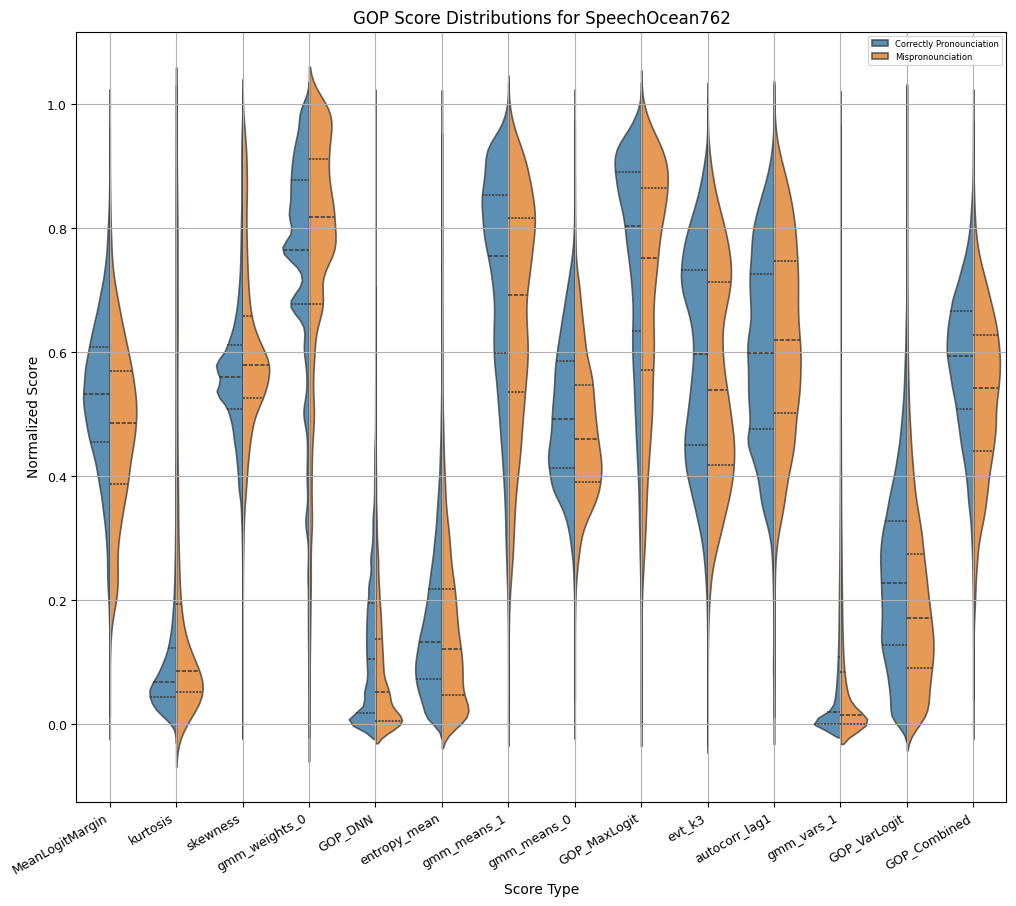

In [30]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Selecting relevant columns for normalization
columns_to_normalize = [
    "mean_logit_margin","kurtosis","skewness","gmm_weights_0","prosetrior_probability", "entropy_mean", "gmm_means_1", "gmm_means_0", 
    "max_logit", "evt_k3", "autocorr_lag1", "gmm_vars_1", "gmm_vars_0", "logit_variance", "combined_score"
]

# Normalizing the scores using Min-Max Scaler
scaler = MinMaxScaler()
df_new_normalized = df.copy()
df_new_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Melt the dataframe for visualization with mispronunciation status
df_melted_new = df_new_normalized.melt(
    id_vars=["mispronounced"], value_vars=columns_to_normalize, 
    var_name="Score Type", value_name="Normalized Score"
)

# Using plain text labels instead of LaTeX for reliability
plain_text_labels = {
    "mean_logit_margin" : "MeanLogitMargin",
    "kurtosis":"kurtosis",
    "skewness":"skewness",
    "gmm_weights_0":"gmm_weights_0",
    "prosetrior_probability": "GOP_DNN",
    "entropy_mean":"entropy_mean",
    "gmm_means_1":"gmm_means_1",
    "gmm_means_0":"gmm_means_0",
    "max_logit": "GOP_MaxLogit",
    "evt_k3":"evt_k3",
    "autocorr_lag1":"autocorr_lag1",
    "gmm_vars_1":"gmm_vars_1",
    "gmm_vars_0":"gmm_vars_1",
    "gmm_weights_1":"gmm_weights_1",
    "logit_variance": "GOP_VarLogit",
    "combined_score": "GOP_Combined"
}

# Replacing the labels in the melted DataFrame
df_melted_new["Score Type"] = df_melted_new["Score Type"].map(plain_text_labels)

# Creating a refined violin plot with better aesthetics and balanced widths
fig, ax = plt.subplots(figsize=(12, 10))  # Larger for readability

# Plotting the violin plot with enhanced aesthetics
sns.violinplot(
    x="Score Type", y="Normalized Score", hue="mispronounced", 
    data=df_melted_new, split=True, inner="quartile", linewidth=1.2, 
    alpha=0.8, ax=ax, density_norm='width'  # Ensuring equal width for both sides
)

# Formatting the plot
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=10)
ax.set_title("GOP Score Distributions for SpeechOcean762", fontsize=12)
ax.set_xlabel("Score Type", fontsize=10)
ax.set_ylabel("Normalized Score", fontsize=10)

# Adjusting legend aesthetics to be clean and readable
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, ["Correctly Pronounciation", "Mispronounciation"],  
    fontsize=6, title_fontsize=7, loc="upper right", frameon=True, markerscale=0.6
)

# Removing grid lines for a cleaner look
ax.grid(True)

# Adjusting tick sizes
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.savefig('gop_experiment1.png',dpi=300) 
# Display the improved plot
plt.show()


In [20]:
# %pip install scikit-learn

In [1]:
import pandas as pd 
df = pd.read_csv("/vol/tensusers6/aparikh/PhD/CTC-based-GOP/quantification/speechocean_evaluation/phoneme_alignment_CTC_SEGMENT_mean.csv")

/tmp/ipykernel_4100476/943549429.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=3)


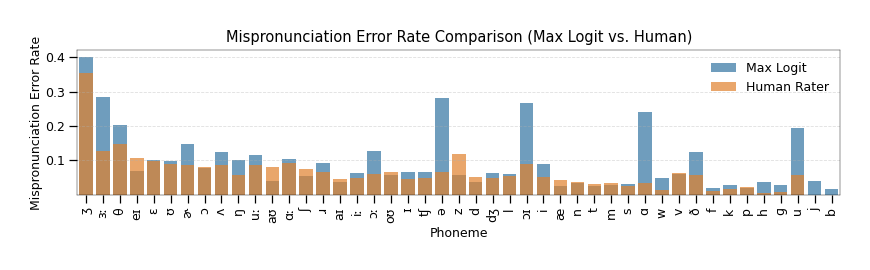

(np.float64(1.7631564712524415), np.float64(0.3500044203541562))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Compute mispronunciation rate per phoneme
phoneme_mispronounce_rate = df.groupby("actual_phoneme")["mispronounced"].mean()

# Sort phonemes by mispronunciation rate in descending order
phoneme_mispronounce_rate_sorted = phoneme_mispronounce_rate.sort_values(ascending=False)

# Find the optimal threshold for max_logit using MCC
percentiles = np.percentile(df["max_logit"], np.arange(1, 100, 1))

best_mcc = -1
best_threshold = None

for threshold in percentiles:
    predictions = df["max_logit"] < threshold  # Predict mispronunciation if max_logit is below threshold
    mcc = matthews_corrcoef(df["mispronounced"], predictions)
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

# Apply the best threshold to determine predicted mispronunciations
df["predicted_mispronounced"] = df["max_logit"] < best_threshold

# Compute error rate per phoneme using max_logit thresholding
phoneme_error_rate_max_logit = df.groupby("actual_phoneme")["predicted_mispronounced"].mean()

# Compute error rate per phoneme using human-rated phoneme accuracy scores
phoneme_error_rate_phoneme_accuracy = df.groupby("actual_phoneme")["phoneme_accuracy"].mean()

# Normalize phoneme accuracy error rate (since higher accuracy means lower error)
phoneme_error_rate_phoneme_accuracy = 1 - (phoneme_error_rate_phoneme_accuracy / phoneme_error_rate_phoneme_accuracy.max())

# Align phonemes across both methods
phonemes_sorted = phoneme_mispronounce_rate_sorted.index

error_rate_max_logit_sorted = phoneme_error_rate_max_logit.reindex(phonemes_sorted)
error_rate_phoneme_accuracy_sorted = phoneme_error_rate_phoneme_accuracy.reindex(phonemes_sorted)

# --- Plot Customization ---
fig, ax = plt.subplots(figsize=(3, 1), dpi=300)  # Compact size

# Bar plots
sns.barplot(x=phonemes_sorted, y=error_rate_max_logit_sorted.values, color="#1f77b4", alpha=0.7, label="Max Logit", ax=ax)
sns.barplot(x=phonemes_sorted, y=error_rate_phoneme_accuracy_sorted.values, color="#ff7f0e", alpha=0.7, label="Human Rater", ax=ax)

# --- Style Adjustments ---
ax.set_xlabel("Phoneme", fontsize=3, labelpad=1)  
ax.set_ylabel("Mispronunciation Error Rate", fontsize=3, labelpad=0.5)
ax.set_title("Mispronunciation Error Rate Comparison (Max Logit vs. Human)", fontsize=3.5, pad=2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=3)  
ax.set_yticks([0.1, 0.2, 0.3, 0.4])  # Set fixed error rate tick labels
ax.set_yticklabels(["0.1", "0.2", "0.3", "0.4"], fontsize=3)  

# Fix the spikes (tick length, thickness, and padding)
plt.tick_params(axis='y', length=2, width=0.3, pad=1)  # Shorter tick marks, closer numbers
plt.tick_params(axis='x', length=2, width=0.3, pad=1)  # Shorter tick marks, closer numbers

# Ensure proper Y-axis limits
ax.set_ylim(0, 0.42)  # Avoid cut-off effects

# Light grid
ax.grid(axis="y", linestyle="--", linewidth=0.2, alpha=0.4)

# Thin border
for spine in ax.spines.values():
    spine.set_linewidth(0.1)

# Legend inside plot
ax.legend(fontsize=3, loc="upper right", frameon=False)

# Reduce padding
#plt.margins(x=0.01, y=0.01)
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
# plot_path = "compact_error_rate_plot.png"
# plt.savefig(plot_path, dpi=600, bbox_inches="tight")

# Display the best threshold and MCC score
best_threshold, best_mcc


In [3]:
phoneme_mispronounce_rate = df.groupby("actual_phoneme")["mispronounced"].mean()

# Sort phonemes by mispronunciation rate in descending order
phoneme_mispronounce_rate_sorted = phoneme_mispronounce_rate.sort_values(ascending=False)

# Find the optimal threshold for max_logit using MCC
percentiles = np.percentile(df["max_logit"], np.arange(1, 100, 1))

best_mcc = -1
best_threshold = None

for threshold in percentiles:
    predictions = df["max_logit"] < threshold  # Predict mispronunciation if max_logit is below threshold
    mcc = matthews_corrcoef(df["mispronounced"], predictions)
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

# Apply the best threshold to determine predicted mispronunciations
df["predicted_mispronounced"] = df["max_logit"] < best_threshold

# Compute error rate per phoneme using max_logit thresholding
phoneme_error_rate_max_logit = df.groupby("actual_phoneme")["predicted_mispronounced"].mean()

# Compute error rate per phoneme using human-rated phoneme accuracy scores
phoneme_error_rate_phoneme_accuracy = df.groupby("actual_phoneme")["phoneme_accuracy"].mean()

# Normalize phoneme accuracy error rate (since higher accuracy means lower error)
phoneme_error_rate_phoneme_accuracy = 1 - (phoneme_error_rate_phoneme_accuracy / phoneme_error_rate_phoneme_accuracy.max())

# Align phonemes across both methods
phonemes_sorted = phoneme_mispronounce_rate_sorted.index

error_rate_max_logit_sorted = phoneme_error_rate_max_logit.reindex(phonemes_sorted)
error_rate_phoneme_accuracy_sorted = phoneme_error_rate_phoneme_accuracy.reindex(phonemes_sorted)

# --- Create DataFrame Comparing Error Rates ---
error_rate_difference = pd.DataFrame({
    "Phoneme": phonemes_sorted,
    "Max Logit Error Rate": error_rate_max_logit_sorted.values,
    "Human Rater Error Rate": error_rate_phoneme_accuracy_sorted.values,
    "Difference (Max Logit - Human)": error_rate_max_logit_sorted.values - error_rate_phoneme_accuracy_sorted.values
})

# Sort the DataFrame by the difference in descending order (largest overestimation at the top)
error_rate_difference_sorted = error_rate_difference.sort_values(by="Difference (Max Logit - Human)", ascending=False)

In [5]:
error_rate_difference_sorted.to_csv("error_rate_difference.csv",index=False)

In [ ]:
# /home/mapleleaf/LCJRepos/projects/Evaluating_Logit-Based_GOP_Scores/official/SO_eval/so_evaluation.ipynb
df.to_csv("quantification_speechocean.csv",index=False)

In [ ]:
print(df.groupby("mispronounced")["prosetrior_probability"].describe())

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Ensure correct interpretation of scores
y_true = df["mispronounced"].astype(int)  # 1 = mispronounced, 0 = correct
y_scores = df["prosetrior_probability"]

# If higher GOP means better pronunciation (opposite of mispronounced), invert it
if df["prosetrior_probability"].corr(df["mispronounced"]) < 0.0:
    y_scores = -y_scores

# Compute AUC normally
roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC AUC: {roc_auc}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
    
)

percentile_values = np.linspace(1, 100, 50)
thresholds = np.percentile(df['prosetrior_probability'], percentile_values)

# Initialize a list to store performance metrics for each threshold
threshold_metrics = []

for threshold in thresholds:
    df['gop_predicted_varied'] = df['prosetrior_probability'] <= threshold

    accuracy = accuracy_score(df['mispronounced'], df['gop_predicted_varied'])
    precision = precision_score(df['mispronounced'], df['gop_predicted_varied'], zero_division=0)
    recall = recall_score(df['mispronounced'], df['gop_predicted_varied'])
    f1 = f1_score(df['mispronounced'], df['gop_predicted_varied'])
    mcc = matthews_corrcoef(df['mispronounced'], df['gop_predicted_varied'])
    roc_auc = roc_auc_score(df['mispronounced'], df['gop_predicted_varied'])

    threshold_metrics.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC Score": mcc,
        "ROC AUC Score": roc_auc
    })

# Convert results to a DataFrame and display
threshold_df = pd.DataFrame(threshold_metrics)
threshold_df


In [ ]:
# Find the threshold where MCC is maximized
best_mcc_row = threshold_df.loc[threshold_df["MCC Score"].idxmax()]

# Print best threshold and corresponding metrics
print("Best Threshold for MCC:", best_mcc_row["Threshold"])
print("Metrics at Best MCC Threshold:")
print(best_mcc_row)

# Report AUC at the threshold where MCC is maximized
print("AUC Score when MCC is Max:", best_mcc_row["ROC AUC Score"])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from scipy import stats
from scipy.stats import pearsonr
import numpy as np


# Separate Train & Test sets based on `is_train` column
train_df = df[df["is_train"] == True]
test_df = df[df["is_train"] == False]

# Prepare Train Data
X_train = train_df["prosetrior_probability"].values.reshape(-1, 1)  # GOP scores
y_train = train_df["phoneme_accuracy"].values  # Human ratings

# Prepare Test Data
X_test = test_df["prosetrior_probability"].values.reshape(-1, 1)
y_test = test_df["phoneme_accuracy"].values

# Transform GOP scores with Polynomial Features (order = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Polynomial Regression Model on Train Set
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on Test Set
y_pred_test = model.predict(X_test_poly)

# Round predictions to nearest valid score (0.1 increments, within min-max range)
y_pred_test_rounded = np.clip(np.round(y_pred_test / 0.1) * 0.1, min(y_test), max(y_test))

# Compute Metrics on Test Set
mse_test = mean_squared_error(y_test, y_pred_test_rounded)
pcc_test, p_value_test = pearsonr(y_test, y_pred_test_rounded)

# Confidence Interval for PCC
pcc_conf_interval_test = stats.pearsonr(y_test, y_pred_test_rounded).confidence_interval(confidence_level=0.95)

# Classification Metrics (Convert to integer classes for evaluation)
y_test_int = y_test.astype(int)
y_pred_test_int = y_pred_test_rounded.astype(int)
conf_matrix_test = confusion_matrix(y_test_int, y_pred_test_int)
class_report_test = classification_report(y_test_int, y_pred_test_int, output_dict=True)

# Store results for Test Set
evaluation_results_test = {
    "MSE (Test Set)": mse_test,
    "PCC (Test Set)": pcc_test,
    "PCC Confidence Interval (Low)": pcc_conf_interval_test.low,
    "PCC Confidence Interval (High)": pcc_conf_interval_test.high,
}

# Display evaluation metrics for Test Set
eval_df_test = pd.DataFrame.from_dict(evaluation_results_test, orient="index", columns=["Value"])
eval_df_test

# Logit scores - Maximum Logit

In [ ]:
print(df.groupby("mispronounced")["max_logit"].describe())

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
    
)

percentile_values = np.linspace(1, 100, 100)
thresholds = np.percentile(df['max_logit'], percentile_values)

# Initialize a list to store performance metrics for each threshold
threshold_metrics = []

for threshold in thresholds:
    df['gop_predicted_varied'] = df['max_logit'] <= threshold

    accuracy = accuracy_score(df['mispronounced'], df['gop_predicted_varied'])
    precision = precision_score(df['mispronounced'], df['gop_predicted_varied'], zero_division=0)
    recall = recall_score(df['mispronounced'], df['gop_predicted_varied'])
    f1 = f1_score(df['mispronounced'], df['gop_predicted_varied'])
    mcc = matthews_corrcoef(df['mispronounced'], df['gop_predicted_varied'])
    roc_auc = roc_auc_score(df['mispronounced'], df['gop_predicted_varied'])

    threshold_metrics.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC Score": mcc,
        "ROC AUC Score": roc_auc
    })

# Convert results to a DataFrame and display
threshold_df = pd.DataFrame(threshold_metrics)



In [ ]:
# Find the threshold where MCC is maximized
best_mcc_row = threshold_df.loc[threshold_df["MCC Score"].idxmax()]

# Print best threshold and corresponding metrics
print("Best Threshold for MCC:", best_mcc_row["Threshold"])
print("Metrics at Best MCC Threshold:")
print(best_mcc_row)

# Report AUC at the threshold where MCC is maximized
print("AUC Score when MCC is Max:", best_mcc_row["ROC AUC Score"])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from scipy import stats
from scipy.stats import pearsonr
import numpy as np


# Separate Train & Test sets based on `is_train` column
train_df = df[df["is_train"] == True]
test_df = df[df["is_train"] == False]

# Prepare Train Data
X_train = train_df["max_logit"].values.reshape(-1, 1)  # GOP scores
y_train = train_df["phoneme_accuracy"].values  # Human ratings

# Prepare Test Data
X_test = test_df["max_logit"].values.reshape(-1, 1)
y_test = test_df["phoneme_accuracy"].values

# Transform GOP scores with Polynomial Features (order = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Polynomial Regression Model on Train Set
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on Test Set
y_pred_test = model.predict(X_test_poly)

# Round predictions to nearest valid score (0.1 increments, within min-max range)
y_pred_test_rounded = np.clip(np.round(y_pred_test / 0.1) * 0.1, min(y_test), max(y_test))

# Compute Metrics on Test Set
mse_test = mean_squared_error(y_test, y_pred_test_rounded)
pcc_test, p_value_test = pearsonr(y_test, y_pred_test_rounded)

# Confidence Interval for PCC
pcc_conf_interval_test = stats.pearsonr(y_test, y_pred_test_rounded).confidence_interval(confidence_level=0.95)

# Classification Metrics (Convert to integer classes for evaluation)
y_test_int = y_test.astype(int)
y_pred_test_int = y_pred_test_rounded.astype(int)
conf_matrix_test = confusion_matrix(y_test_int, y_pred_test_int)
class_report_test = classification_report(y_test_int, y_pred_test_int, output_dict=True)

# Store results for Test Set
evaluation_results_test = {
    "MSE (Test Set)": mse_test,
    "PCC (Test Set)": pcc_test,
    "PCC Confidence Interval (Low)": pcc_conf_interval_test.low,
    "PCC Confidence Interval (High)": pcc_conf_interval_test.high,
}

# Display evaluation metrics for Test Set
eval_df_test = pd.DataFrame.from_dict(evaluation_results_test, orient="index", columns=["Value"])
eval_df_test

## Logit Margin score

In [ ]:
print(df.groupby("mispronounced")["mean_logit_margin"].describe())

In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
    
)

percentile_values = np.linspace(1, 100, 20)
thresholds = np.percentile(df['mean_logit_margin'], percentile_values)

# Initialize a list to store performance metrics for each threshold
threshold_metrics = []

for threshold in thresholds:
    df['gop_predicted_varied'] = df['mean_logit_margin'] < threshold

    accuracy = accuracy_score(df['mispronounced'], df['gop_predicted_varied'])
    precision = precision_score(df['mispronounced'], df['gop_predicted_varied'], zero_division=0)
    recall = recall_score(df['mispronounced'], df['gop_predicted_varied'])
    f1 = f1_score(df['mispronounced'], df['gop_predicted_varied'])
    mcc = matthews_corrcoef(df['mispronounced'], df['gop_predicted_varied'])
    roc_auc = roc_auc_score(df['mispronounced'], df['gop_predicted_varied'])

    threshold_metrics.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC Score": mcc,
        "ROC AUC Score": roc_auc
    })

# Convert results to a DataFrame and display
threshold_df = pd.DataFrame(threshold_metrics)



In [ ]:
threshold_df

In [ ]:
# Find the threshold where MCC is maximized
best_mcc_row = threshold_df.loc[threshold_df["MCC Score"].idxmax()]

# Print best threshold and corresponding metrics
print("Best Threshold for MCC:", best_mcc_row["Threshold"])
print("Metrics at Best MCC Threshold:")
print(best_mcc_row)

# Report AUC at the threshold where MCC is maximized
print("AUC Score when MCC is Max:", best_mcc_row["ROC AUC Score"])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from scipy import stats
from scipy.stats import pearsonr
import numpy as np


# Separate Train & Test sets based on `is_train` column
train_df = df[df["is_train"] == True]
test_df = df[df["is_train"] == False]

# Prepare Train Data
X_train = train_df["mean_logit_margin"].values.reshape(-1, 1)  # GOP scores
y_train = train_df["phoneme_accuracy"].values  # Human ratings

# Prepare Test Data
X_test = test_df["mean_logit_margin"].values.reshape(-1, 1)
y_test = test_df["phoneme_accuracy"].values

# Transform GOP scores with Polynomial Features (order = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Polynomial Regression Model on Train Set
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on Test Set
y_pred_test = model.predict(X_test_poly)

# Round predictions to nearest valid score (0.1 increments, within min-max range)
y_pred_test_rounded = np.clip(np.round(y_pred_test / 0.1) * 0.1, min(y_test), max(y_test))

# Compute Metrics on Test Set
mse_test = mean_squared_error(y_test, y_pred_test_rounded)
pcc_test, p_value_test = pearsonr(y_test, y_pred_test_rounded)

# Confidence Interval for PCC
pcc_conf_interval_test = stats.pearsonr(y_test, y_pred_test_rounded).confidence_interval(confidence_level=0.95)

# Classification Metrics (Convert to integer classes for evaluation)
y_test_int = y_test.astype(int)
y_pred_test_int = y_pred_test_rounded.astype(int)
conf_matrix_test = confusion_matrix(y_test_int, y_pred_test_int)
class_report_test = classification_report(y_test_int, y_pred_test_int, output_dict=True)

# Store results for Test Set
evaluation_results_test = {
    "MSE (Test Set)": mse_test,
    "PCC (Test Set)": pcc_test,
    "PCC Confidence Interval (Low)": pcc_conf_interval_test.low,
    "PCC Confidence Interval (High)": pcc_conf_interval_test.high,
}

# Display evaluation metrics for Test Set
eval_df_test = pd.DataFrame.from_dict(evaluation_results_test, orient="index", columns=["Value"])
eval_df_test

# Combined Score

In [ ]:
print(df.groupby("mispronounced")["combined_score"].describe())

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
    
)

percentile_values = np.linspace(1, 100, 20)
thresholds = np.percentile(df['combined_score'], percentile_values)

# Initialize a list to store performance metrics for each threshold
threshold_metrics = []

for threshold in thresholds:
    df['gop_predicted_varied'] = df['combined_score'] <= threshold

    accuracy = accuracy_score(df['mispronounced'], df['gop_predicted_varied'])
    precision = precision_score(df['mispronounced'], df['gop_predicted_varied'], zero_division=0)
    recall = recall_score(df['mispronounced'], df['gop_predicted_varied'])
    f1 = f1_score(df['mispronounced'], df['gop_predicted_varied'])
    mcc = matthews_corrcoef(df['mispronounced'], df['gop_predicted_varied'])
    roc_auc = roc_auc_score(df['mispronounced'], df['gop_predicted_varied'])

    threshold_metrics.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC Score": mcc,
        "ROC AUC Score": roc_auc
    })

# Convert results to a DataFrame and display
threshold_df = pd.DataFrame(threshold_metrics)



In [ ]:
# Find the threshold where MCC is maximized
best_mcc_row = threshold_df.loc[threshold_df["MCC Score"].idxmax()]

# Print best threshold and corresponding metrics
print("Best Threshold for MCC:", best_mcc_row["Threshold"])
print("Metrics at Best MCC Threshold:")
print(best_mcc_row)

# Report AUC at the threshold where MCC is maximized
print("AUC Score when MCC is Max:", best_mcc_row["ROC AUC Score"])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from scipy import stats
from scipy.stats import pearsonr
import numpy as np


# Separate Train & Test sets based on `is_train` column
train_df = df[df["is_train"] == True]
test_df = df[df["is_train"] == False]

# Prepare Train Data
X_train = train_df["combined_score"].values.reshape(-1, 1)  # GOP scores
y_train = train_df["phoneme_accuracy"].values  # Human ratings

# Prepare Test Data
X_test = test_df["combined_score"].values.reshape(-1, 1)
y_test = test_df["phoneme_accuracy"].values

# Transform GOP scores with Polynomial Features (order = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Polynomial Regression Model on Train Set
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on Test Set
y_pred_test = model.predict(X_test_poly)

# Round predictions to nearest valid score (0.1 increments, within min-max range)
y_pred_test_rounded = np.clip(np.round(y_pred_test / 0.1) * 0.1, min(y_test), max(y_test))

# Compute Metrics on Test Set
mse_test = mean_squared_error(y_test, y_pred_test_rounded)
pcc_test, p_value_test = pearsonr(y_test, y_pred_test_rounded)

# Confidence Interval for PCC
pcc_conf_interval_test = stats.pearsonr(y_test, y_pred_test_rounded).confidence_interval(confidence_level=0.95)

# Classification Metrics (Convert to integer classes for evaluation)
y_test_int = y_test.astype(int)
y_pred_test_int = y_pred_test_rounded.astype(int)
conf_matrix_test = confusion_matrix(y_test_int, y_pred_test_int)
class_report_test = classification_report(y_test_int, y_pred_test_int, output_dict=True)

# Store results for Test Set
evaluation_results_test = {
    "MSE (Test Set)": mse_test,
    "PCC (Test Set)": pcc_test,
    "PCC Confidence Interval (Low)": pcc_conf_interval_test.low,
    "PCC Confidence Interval (High)": pcc_conf_interval_test.high,
}

# Display evaluation metrics for Test Set
eval_df_test = pd.DataFrame.from_dict(evaluation_results_test, orient="index", columns=["Value"])
eval_df_test

In [ ]:
print(df.groupby("mispronounced")["logit_variance"].describe())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
    
)

percentile_values = np.linspace(1, 100, 20)
thresholds = np.percentile(df['logit_variance'], percentile_values)

# Initialize a list to store performance metrics for each threshold
threshold_metrics = []

for threshold in thresholds:
    df['gop_predicted_varied'] = df['logit_variance'] <= threshold

    accuracy = accuracy_score(df['mispronounced'], df['gop_predicted_varied'])
    precision = precision_score(df['mispronounced'], df['gop_predicted_varied'], zero_division=0)
    recall = recall_score(df['mispronounced'], df['gop_predicted_varied'])
    f1 = f1_score(df['mispronounced'], df['gop_predicted_varied'])
    mcc = matthews_corrcoef(df['mispronounced'], df['gop_predicted_varied'])
    roc_auc = roc_auc_score(df['mispronounced'], df['gop_predicted_varied'])

    threshold_metrics.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC Score": mcc,
        "ROC AUC Score": roc_auc
    })

# Convert results to a DataFrame and display
threshold_df = pd.DataFrame(threshold_metrics)
threshold_df


In [ ]:
# Find the threshold where MCC is maximized
best_mcc_row = threshold_df.loc[threshold_df["MCC Score"].idxmax()]

# Print best threshold and corresponding metrics
print("Best Threshold for MCC:", best_mcc_row["Threshold"])
print("Metrics at Best MCC Threshold:")
print(best_mcc_row)

# Report AUC at the threshold where MCC is maximized
print("AUC Score when MCC is Max:", best_mcc_row["ROC AUC Score"])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from scipy import stats
from scipy.stats import pearsonr
import numpy as np


# Separate Train & Test sets based on `is_train` column
train_df = df[df["is_train"] == True]
test_df = df[df["is_train"] == False]

# Prepare Train Data
X_train = train_df["logit_variance"].values.reshape(-1, 1)  # GOP scores
y_train = train_df["phoneme_accuracy"].values  # Human ratings

# Prepare Test Data
X_test = test_df["logit_variance"].values.reshape(-1, 1)
y_test = test_df["phoneme_accuracy"].values

# Transform GOP scores with Polynomial Features (order = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Polynomial Regression Model on Train Set
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on Test Set
y_pred_test = model.predict(X_test_poly)

# Round predictions to nearest valid score (0.1 increments, within min-max range)
y_pred_test_rounded = np.clip(np.round(y_pred_test / 0.1) * 0.1, min(y_test), max(y_test))

# Compute Metrics on Test Set
mse_test = mean_squared_error(y_test, y_pred_test_rounded)
pcc_test, p_value_test = pearsonr(y_test, y_pred_test_rounded)

# Confidence Interval for PCC
pcc_conf_interval_test = stats.pearsonr(y_test, y_pred_test_rounded).confidence_interval(confidence_level=0.95)

# Classification Metrics (Convert to integer classes for evaluation)
y_test_int = y_test.astype(int)
y_pred_test_int = y_pred_test_rounded.astype(int)
conf_matrix_test = confusion_matrix(y_test_int, y_pred_test_int)
class_report_test = classification_report(y_test_int, y_pred_test_int, output_dict=True)

# Store results for Test Set
evaluation_results_test = {
    "MSE (Test Set)": mse_test,
    "PCC (Test Set)": pcc_test,
    "PCC Confidence Interval (Low)": pcc_conf_interval_test.low,
    "PCC Confidence Interval (High)": pcc_conf_interval_test.high,
}

# Display evaluation metrics for Test Set
eval_df_test = pd.DataFrame.from_dict(evaluation_results_test, orient="index", columns=["Value"])
eval_df_test